# Подготовка датасета

In [1]:
import pandas as pd
from sklearn.metrics import r2_score
import matplotlib.pyplot as plt


def add_next_part(df, next_part):
    return pd.concat([df, next_part], ignore_index=True)

def replace_commas_and_convert_to_float(value):
    return float(value.replace(',', '.'))

feature = 'Отделка'

flats_df = pd.read_excel('../cian_spb.xlsx')
flats_df = flats_df.loc[:, [feature, "Общая площадь", "Жилая площадь", "Площадь кухни", "Стоимость"]]
flats_df.dropna(inplace=True)
numeric_columns = ["Общая площадь", "Жилая площадь", "Площадь кухни"]
flats_df[numeric_columns] = flats_df[numeric_columns].map(replace_commas_and_convert_to_float)
flats_df = flats_df.sample(frac=1)
flats_df

,Отделка,Общая площадь,Жилая площадь,Площадь кухни,Стоимость
688,Без отделки,42.09,15.9,16.8,9000000
418,Без отделки,38.50,13.6,15.4,6999990
191,Чистовая,30.93,12.4,10.0,6250000
704,Чистовая,22.07,14.1,3.0,6670000
454,Без отделки,81.70,41.3,20.5,22204099
...,...,...,...,...,...
513,Чистовая,56.99,29.5,14.7,13440000
268,Без отделки,37.32,14.3,12.4,16300000
1173,Без отделки,33.70,9.6,14.7,4819100
28,Предчистовая,23.60,11.2,5.8,5711200


In [16]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split

train_ratio = 0.8

df = flats_df
df = df.dropna(ignore_index=True)
target = pd.Series(pd.factorize(df[feature])[0])
df = df.iloc[:, 1:]
for column in df:
    mean = df[column].mean()
    std = df[column].std()
    outliers = np.where((df[column] - mean) / std >= 3)[0]
    df = df.drop(index=outliers).reset_index(drop=True)
    target = target.drop(index=outliers).reset_index(drop=True)

df = (df - df.mean()) / df.std()
X_train, X_test, y_train, y_test = train_test_split(df, target, train_size=train_ratio)

In [3]:
df

,Общая площадь,Жилая площадь,Площадь кухни,Стоимость
0,-0.995970,-0.749264,-1.191356,-0.695656
1,-0.603558,-0.765403,-0.485068,-0.620975
2,0.622347,0.340111,0.799092,0.124158
3,1.537104,1.542457,1.376965,1.162016
4,-0.766954,-0.491042,-1.191356,-0.619100
...,...,...,...,...
718,-0.302405,-0.458764,0.397792,0.034526
719,-0.356291,-0.466833,-0.131924,-0.515750
720,-0.289369,-0.523319,0.397792,-0.517057
721,0.644944,0.695166,0.478052,-0.023064


# Подбор гиперпараметров

In [4]:
import optuna
from knn import KnnClassifier
from sklearn.metrics import accuracy_score

train_size = int(X_train.shape[0] * train_ratio)
train_data = X_train[: train_size]
valid_data = X_train[train_size:]
train_target = y_train[: train_size]
valid_target = y_train[train_size :]

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Для собственной реализации

In [5]:
def my_objective(trial):
    neighbors = trial.suggest_int('neighbors', 1, 50, log=True)
    window = trial.suggest_categorical('window', ['unfixed', 'fixed'])
    kernel = trial.suggest_categorical('kernel', ['uniform', 'gaussian', 'common'])
    metric = trial.suggest_categorical('metric', ['minkowski', 'chebyshev', 'cosine'])
    h, a, b, p = 1, 1, 1, 1
    if window == 'fixed':
        h = trial.suggest_float('h', 1e-2, 1e2, log=True)
    if kernel == 'common':
        a = trial.suggest_int('a', 1, 4)
        b = trial.suggest_int('b', 1, 4)
    if metric == 'minkowski':
        p = trial.suggest_int('p', 1, 4)
    classifier = KnnClassifier(neighbors, window, h, kernel, a, b, metric, p)
    classifier.fit(train_data, train_target)
    return accuracy_score(valid_target, classifier.predict(valid_data))

study = optuna.create_study(direction='maximize')
study.optimize(my_objective, n_trials=100)
print(study.best_params)

[I 2024-10-17 11:28:31,071] A new study created in memory with name: no-name-4d612854-06a1-47f8-bc3e-231edb198a78
[I 2024-10-17 11:28:31,078] Trial 0 finished with value: 0.6120689655172413 and parameters: {'neighbors': 2, 'window': 'unfixed', 'kernel': 'gaussian', 'metric': 'minkowski', 'p': 1}. Best is trial 0 with value: 0.6120689655172413.
[I 2024-10-17 11:28:31,203] Trial 1 finished with value: 0.5517241379310345 and parameters: {'neighbors': 2, 'window': 'fixed', 'kernel': 'common', 'metric': 'chebyshev', 'h': 25.53646964469656, 'a': 2, 'b': 4}. Best is trial 0 with value: 0.6120689655172413.
[I 2024-10-17 11:28:31,473] Trial 2 finished with value: 0.5517241379310345 and parameters: {'neighbors': 1, 'window': 'fixed', 'kernel': 'gaussian', 'metric': 'cosine', 'h': 16.58686216957199}. Best is trial 0 with value: 0.6120689655172413.
[I 2024-10-17 11:28:31,695] Trial 3 finished with value: 0.5517241379310345 and parameters: {'neighbors': 1, 'window': 'fixed', 'kernel': 'uniform', 'm

{'neighbors': 7, 'window': 'unfixed', 'kernel': 'common', 'metric': 'minkowski', 'a': 3, 'b': 3, 'p': 3}


## Для реализации sklearn

In [6]:
from sklearn.neighbors import KNeighborsClassifier

def sklearn_objective(trial):
    neighbors = trial.suggest_int('neighbors', 1, 50, log=True)
    weights = trial.suggest_categorical('weights', ['uniform', 'distance'])
    metric = trial.suggest_categorical('metric', ['minkowski', 'cosine'])
    p = 1
    if metric == 'minkowski':
        p = trial.suggest_int('p', 1, 4)
    classifier = KNeighborsClassifier(neighbors, weights=weights, metric=metric, p=p, n_jobs=1)
    classifier.fit(train_data, train_target)
    return accuracy_score(valid_target, classifier.predict(valid_data))

study = optuna.create_study(direction='maximize')
study.optimize(sklearn_objective, n_trials=100)
print(study.best_params)

[I 2024-10-17 11:28:34,185] A new study created in memory with name: no-name-c0733288-a600-488e-b85c-efa6e59bd687
[I 2024-10-17 11:28:34,189] Trial 0 finished with value: 0.6637931034482759 and parameters: {'neighbors': 7, 'weights': 'distance', 'metric': 'minkowski', 'p': 3}. Best is trial 0 with value: 0.6637931034482759.
[I 2024-10-17 11:28:34,192] Trial 1 finished with value: 0.646551724137931 and parameters: {'neighbors': 10, 'weights': 'uniform', 'metric': 'cosine'}. Best is trial 0 with value: 0.6637931034482759.
[I 2024-10-17 11:28:34,195] Trial 2 finished with value: 0.603448275862069 and parameters: {'neighbors': 9, 'weights': 'uniform', 'metric': 'cosine'}. Best is trial 0 with value: 0.6637931034482759.
[I 2024-10-17 11:28:34,197] Trial 3 finished with value: 0.6810344827586207 and parameters: {'neighbors': 11, 'weights': 'distance', 'metric': 'minkowski', 'p': 1}. Best is trial 3 with value: 0.6810344827586207.
[I 2024-10-17 11:28:34,200] Trial 4 finished with value: 0.715

{'neighbors': 25, 'weights': 'distance', 'metric': 'minkowski', 'p': 4}


# Зависимость функции качества от числа соседей

In [7]:
neighbors_range = range(1, 51)
size = len(neighbors_range)

my_train_accuracy = [0.0] * size
my_test_accuracy = [0.0] * size
classifier = KnnClassifier(1, window_type='unfixed', kernel='gaussian', metric='minkowski', p=1)
classifier.fit(X_train, y_train)
for neighbors in neighbors_range:
    classifier.neighbors_number = neighbors
    my_train_accuracy[neighbors - 1] = accuracy_score(y_train, classifier.predict(X_train))
    my_test_accuracy[neighbors - 1] = accuracy_score(y_test, classifier.predict(X_test))
    
sklearn_train_accuracy = [0.0] * size
sklearn_test_accuracy = [0.0] * size
for neighbors in neighbors_range:
    classifier = KNeighborsClassifier(neighbors, weights='distance', metric='minkowski', p=1, n_jobs=1)
    classifier.fit(X_train, y_train)
    sklearn_train_accuracy[neighbors - 1] = accuracy_score(y_train, classifier.predict(X_train))
    sklearn_test_accuracy[neighbors - 1] = accuracy_score(y_test, classifier.predict(X_test))

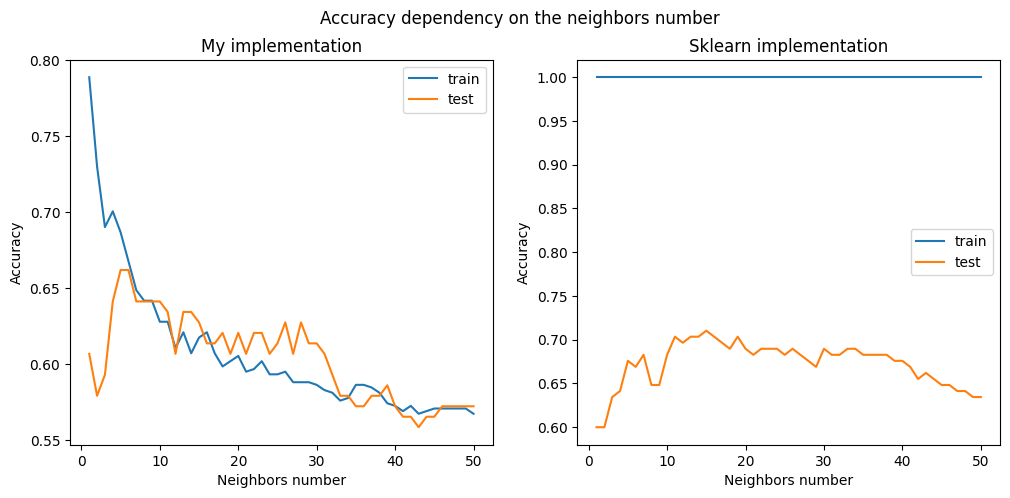

In [8]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(1, 2, figsize=(12, 5))
fig.suptitle('Accuracy dependency on the neighbors number')
ax[0].set_title('My implementation')
ax[0].set_xlabel('Neighbors number')
ax[0].set_ylabel('Accuracy')
ax[0].plot(neighbors_range, my_train_accuracy, label='train')
ax[0].plot(neighbors_range, my_test_accuracy, label='test')
ax[0].legend()

ax[1].set_title('Sklearn implementation')
ax[1].set_xlabel('Neighbors number')
ax[1].set_ylabel('Accuracy')
ax[1].plot(neighbors_range, sklearn_train_accuracy, label='train')
ax[1].plot(neighbors_range, sklearn_test_accuracy, label='test')
ax[1].legend()

# Взвешивание объектов методом LOWESS

In [12]:
from lowess import Lowess
from knn import KnnClassifier
from sklearn.metrics import accuracy_score
# {'neighbors': 7, 'window': 'unfixed', 'kernel': 'common', 'metric': 'minkowski', 'a': 3, 'b': 3, 'p': 3}
lowess = Lowess(7, knn_kernel='common', lowess_kernel='common', metric='minkowski', p=3,knn_a=3, knn_b=3, lowess_a=3, lowess_b=3)
weights = lowess.get_weights(X_train, y_train)

## Для собственной реализации

In [13]:
classifier = KnnClassifier(12, window_type='unfixed', kernel='gaussian', metric='minkowski', p=1)

classifier.fit(X_train, y_train)
print('До взвешивания: ', accuracy_score(y_test, classifier.predict(X_test)))

classifier.fit(X_train, y_train, weights)
print('После взвешивания: ', accuracy_score(y_test, classifier.predict(X_test)))

До взвешивания:  0.6068965517241379
После взвешивания:  0.6206896551724138


## Для реализации sklearn

In [14]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score

oversampled_X_train = X_train.sample(frac=10, replace=True, weights=weights, random_state=42)
oversampled_y_train = y_train.sample(frac=10, replace=True, weights=weights, random_state=42)
classifier = KNeighborsClassifier(18, weights='distance', metric='minkowski', p=1, n_jobs=1)
classifier.fit(X_train, y_train)
print('До взвешивания: ', accuracy_score(y_test, classifier.predict(X_test)))

classifier = KNeighborsClassifier(180, weights='distance', metric='minkowski', p=1, n_jobs=1)
classifier.fit(oversampled_X_train, oversampled_y_train)
print('После взвешивания: ', accuracy_score(y_test, classifier.predict(X_test)))

До взвешивания:  0.6896551724137931
После взвешивания:  0.6620689655172414
